In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 데이터 원본 파일 불러오기
dataset = pd.read_csv('data/Churn.csv')
dataset.shape

(10000, 14)

## Feature 해석하기

- 전부 결측값이 없음을 알 수 있다.

### 범주형 데이터
1. 명목형 피처 : Geography
    - Geography는 3종류 지역임을 알 수 있으며 object 타입으로 되어있다.
        - 인코딩이 필요하다.
    - 이진 피처 : Gender, HasCrCard, IsActiveMember, **Exited(target)**
        - 고윳값이 모두 2개이다.
        - Gender는 object 타입으로 되어 있지만 나머지는 int 타입으로 되어있다.
            - 인코딩이 필요하다
2. 순서형 피처 : 없음


### 수치형 데이터
1. 이산형 데이터 : NumOfProducts
    - 고윳값이 4개이다.
    - int 타입으로 되어 있다.
2. 연속형 데이터 : CreditScore, Age, Balance, EstimatedSalary
    - 고윳값이 다 다르지만 EstimatedSalary는 하나만 중복되어 있다.
    - CreditScore, Age는 int 타입, Balance, EstimatedSalary는 float 타입으로 되어있다.

---

- 그 외 데이터 : RowNumber, CustomerId, Surname
    - 필요 없는 데이터 이므로 제거하겠다.

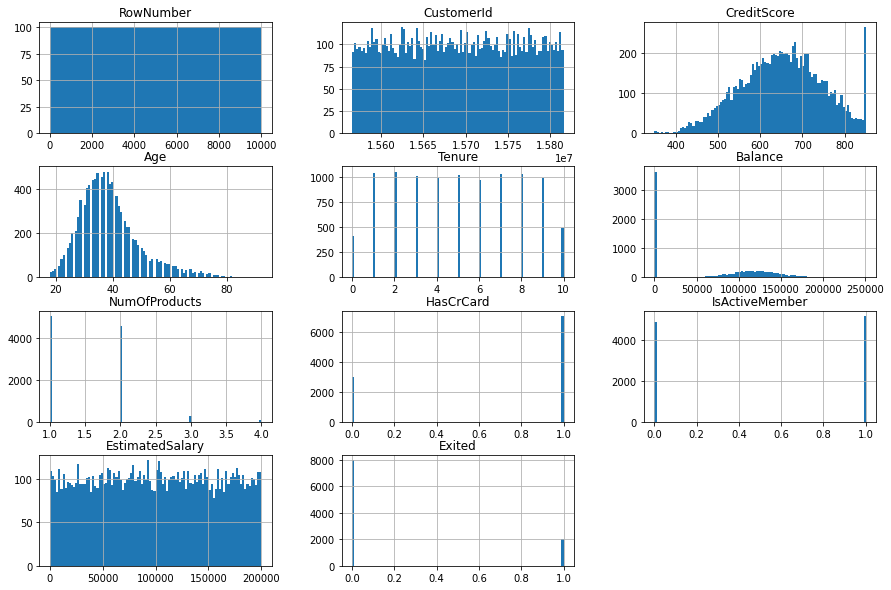

In [3]:
_ = dataset.hist(bins=100, figsize=(15, 10))

In [4]:
# feature 요약표
def resumetable(df):
    print(f'데이터셋 형상 : {df.shape}')
    summary =pd.DataFrame(df.dtypes, columns=['dtype'])\
                .reset_index().rename(columns={'index' : 'feature'})
    
    summary['null'] = df.isnull().sum().values # 결측값 개수
    summary['nunique'] = df.nunique().values # 고윳값 개수
    
    return summary

resumetable(dataset)

데이터셋 형상 : (10000, 14)


,feature,dtype,null,nunique
0,RowNumber,int64,0,10000
1,CustomerId,int64,0,10000
2,Surname,object,0,2932
3,CreditScore,int64,0,460
4,Geography,object,0,3
5,Gender,object,0,2
6,Age,int64,0,70
7,Tenure,int64,0,11
8,Balance,float64,0,6382
9,NumOfProducts,int64,0,4


In [5]:
dataset.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## target 분포

약 8 대 2 비율임을 알 수 있다.  
그러나 SMOTE 오버 샘플링을 쓰면 오히려 성능이 떨어진다.

In [6]:
dataset['Exited'].value_counts(normalize=True) * 100

0    79.63
1    20.37
Name: Exited, dtype: float64

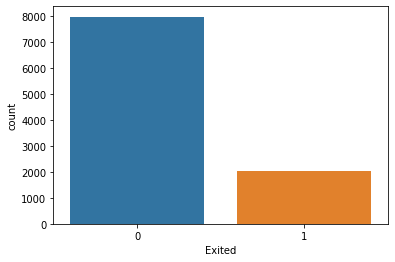

In [7]:
sns.countplot(x = 'Exited', data=dataset)
plt.show()

## Feature Engineering

In [8]:
# 필요 없는 피처 제거
drop_features = ['RowNumber', 'Surname', 'CustomerId']
dataset = dataset.drop(drop_features, axis=1)

In [9]:
# 원-핫 인코딩
ohe_features = ['Geography', 'Gender']

dataset = pd.get_dummies(dataset, columns=ohe_features)

dataset.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


# Baseline model

1. 환경 설정
    - 시드값 고정
    - target 지정
2. 데이터 준비
    - 훈련/학습 데이터 분리
3. 모델 구성
5. 성능 검증
6. 예측 및 제출

In [10]:
import tensorflow as tf

# 시드값 고정
seed = 42
# target 지정
label_name = 'Exited'

In [11]:
# train set, test set 나누기
X_train = dataset.sample(frac = 0.8, random_state = seed)
X_test = dataset.drop(X_train.index)

In [12]:
# target 나누기
y_train = X_train.pop(label_name)
y_test = X_test.pop(label_name)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 13), (2000, 13), (8000,), (2000,))

In [13]:
# input shape
input_shape = len(X_train.keys())

# 모델 구성
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=[input_shape]),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                448       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 993
Trainable params: 993
Non-trainable params: 0
_________________________________________________________________


In [14]:
# patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)

# 모델 훈련
history = model.fit(X_train, y_train, epochs=1000000, callbacks=[early_stop])

Epoch 1/1000000
250/250 [==============================] - 1s 825us/step - loss: 100.8062 - accuracy: 0.6823
Epoch 2/1000000
250/250 [==============================] - 0s 801us/step - loss: 43.4738 - accuracy: 0.6810
Epoch 3/1000000
250/250 [==============================] - 0s 794us/step - loss: 28.2086 - accuracy: 0.6829
Epoch 4/1000000
250/250 [==============================] - 0s 793us/step - loss: 25.5964 - accuracy: 0.6864
Epoch 5/1000000
250/250 [==============================] - 0s 781us/step - loss: 37.8221 - accuracy: 0.6800
Epoch 6/1000000
250/250 [==============================] - 0s 786us/step - loss: 28.4533 - accuracy: 0.6743
Epoch 7/1000000
250/250 [==============================] - 0s 786us/step - loss: 33.2335 - accuracy: 0.6809
Epoch 8/1000000
250/250 [==============================] - 0s 779us/step - loss: 31.2447 - accuracy: 0.6826
Epoch 9/1000000
250/250 [==============================] - 0s 781us/step - loss: 37.0377 - accuracy: 0.6798
Epoch 10/1000000
250/250 [=

In [15]:
hist = pd.DataFrame(history.history)
hist.tail()

,loss,accuracy
145,0.507753,0.796875
146,0.504599,0.796875
147,0.504535,0.796750
148,0.504732,0.796750
149,0.504677,0.796625


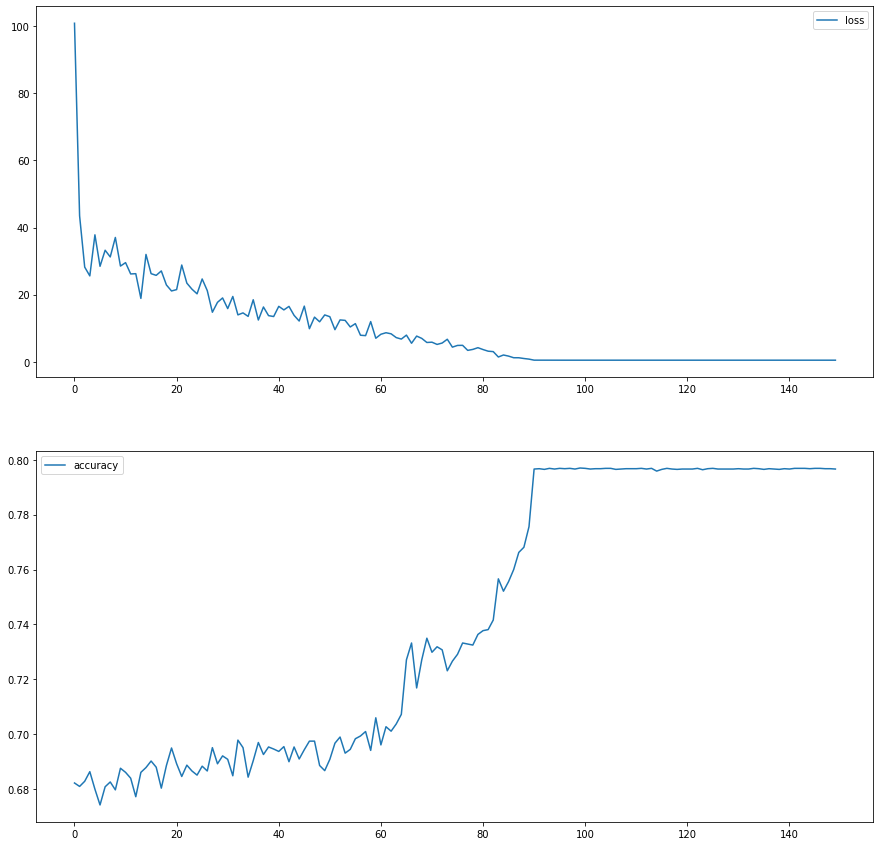

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
hist[['loss']].plot(ax=axes[0])
hist[['accuracy']].plot(ax=axes[1])
plt.show()

In [17]:
# 정확도 평가
test_loss, test_acc = model.evaluate(X_test, y_test)

print('\nTest accuracy:', test_acc)

63/63 [==============================] - 0s 639us/step - loss: 0.5128 - accuracy: 0.7930

Test accuracy: 0.7929999828338623
